<a href="https://colab.research.google.com/github/fintech-dl-hse/course/blob/main/seminars/08_seminar.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Word2Vec


In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [13]:
common_texts[:10]

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [ ]:
skipgram = 1 # 1 / 0
negative_samplig = 5
w2v_model = Word2Vec(sentences=common_texts, size=100, window=5, min_count=1, workers=4, sg=skipgram, negative=negative_samplig)
w2v_model.save("word2vec.model")

In [ ]:
vector = w2v_model.wv['computer']  # get numpy vector of a word
sims = w2v_model.wv.most_similar('computer', topn=10)  # get other similar words
sims

[('user', 0.1467563360929489),
 ('interface', 0.12252745032310486),
 ('response', 0.08799518644809723),
 ('minors', 0.07840339839458466),
 ('time', 0.03845221921801567),
 ('trees', 0.0367119237780571),
 ('graph', -0.03798753023147583),
 ('system', -0.06022052466869354),
 ('human', -0.09970732033252716),
 ('eps', -0.10036389529705048)]

In [ ]:
w2v_model

In [15]:
w2v_model.wv['human'].shape

(100,)

In [ ]:
result = w2v_model.most_similar(positive=['human', 'system'], negative=['computer'], topn=1)
print(result)

[('trees', 0.12913841009140015)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


### Предобученные эмбеддинги

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-22 22:22:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-22 22:22:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-22 22:22:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec('glove.6B.100d.txt', 'glove.6B.100d.txt.word2vec')

(400000, 100)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print(result)

[('queen', 0.7698541283607483)]


# [FastText](https://github.com/facebookresearch/fastText)

[supervised-tutorial](https://fasttext.cc/docs/en/supervised-tutorial.html)

[unsupervised-tutorial](https://fasttext.cc/docs/en/unsupervised-tutorial.html)

[help](https://fasttext.cc/docs/en/python-module.html)

[python reimplementation](http://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html)

```
word_emb = word_emb + sum( subword_embeddings )
```

In [ ]:
w2v_model.wv['abracadabra']

KeyError: ignored

In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz && tar xvzf cooking.stackexchange.tar.gz

--2022-03-22 22:48:39--  https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457609 (447K) [application/x-tar]
Saving to: ‘cooking.stackexchange.tar.gz’

cooking.stackexchan 100%[===================>] 446.88K  1.36MB/s    in 0.3s    

2022-03-22 22:48:40 (1.36 MB/s) - ‘cooking.stackexchange.tar.gz’ saved [457609/457609]

cooking.stackexchange.id
cooking.stackexchange.txt
readme.txt


In [17]:
! head cooking.stackexchange.txt

__label__sauce __label__cheese How much does potato starch affect a cheese sauce recipe?
__label__food-safety __label__acidity Dangerous pathogens capable of growing in acidic environments
__label__cast-iron __label__stove How do I cover up the white spots on my cast iron stove?
__label__restaurant Michelin Three Star Restaurant; but if the chef is not there
__label__knife-skills __label__dicing Without knife skills, how can I quickly and accurately dice vegetables?
__label__storage-method __label__equipment __label__bread What's the purpose of a bread box?
__label__baking __label__food-safety __label__substitutions __label__peanuts how to seperate peanut oil from roasted peanuts at home?
__label__chocolate American equivalent for British chocolate terms
__label__baking __label__oven __label__convection Fan bake vs bake
__label__sauce __label__storage-lifetime __label__acidity __label__mayonnaise Regulation and balancing of readymade packed mayonnaise and other sauces


In [18]:
! head -n 12404 cooking.stackexchange.txt > cooking.train
! tail -n 3000 cooking.stackexchange.txt > cooking.valid

In [19]:
!pip install fasttext

     |████████████████████████████████| 68 kB 5.3 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3139533 sha256=478d1d886de93529da242136125cd522fdd4c852cd6ab3e616f35db5296c9ca0
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [20]:
import fasttext

ft_model = fasttext.train_supervised(input="cooking.train", minn=3, maxn=6, dim=100)

In [21]:
ft_model.predict("Which baking dish is best to bake a banana bread ?")

(('__label__baking',), array([0.00184464]))

In [22]:
ft_model.test("cooking.valid") # N, P@1, R@1

(3000, 0.096, 0.04151650569410408)

In [23]:
!grep -c abracdabra cooking.train

0


In [24]:
ft_model['dab']

array([ 1.68020895e-04,  4.51601591e-05, -5.14288840e-04, -1.60145544e-04,
        3.63977771e-04, -2.06045326e-04,  1.23952643e-03,  5.03843999e-04,
        4.73251159e-04,  5.25946416e-05,  8.16813728e-04,  1.60578603e-03,
       -3.61540879e-04, -4.96256107e-04, -2.93571720e-05, -1.24202506e-03,
       -4.98984416e-04, -1.25787861e-03, -9.98524833e-04, -3.70868278e-04,
        6.13538781e-04, -6.90861722e-04,  5.93442164e-05, -1.78122474e-03,
       -1.52719615e-03,  2.90485448e-04, -8.34761304e-04,  6.15805038e-04,
       -1.08085037e-03,  1.28276821e-03, -1.06472646e-04,  5.93195844e-04,
       -8.37484025e-04,  8.91225238e-04, -1.44962367e-04,  3.45618260e-04,
       -5.93322620e-04, -6.50832662e-04,  2.18673726e-04, -1.20386097e-03,
       -8.49472068e-04, -1.98841197e-04,  1.07815792e-03, -1.20035361e-03,
        1.11841224e-03,  1.14627054e-03, -2.01708492e-04,  1.09654444e-03,
       -1.18399307e-03,  9.65096522e-04, -2.09229300e-03,  6.76721684e-04,
       -3.39861697e-04, -

In [25]:
ft_model.get_words()[:10]

['</s>', 'to', 'a', 'the', 'How', 'I', 'in', 'of', 'for', 'What']

In [26]:
ft_model.get_subwords("abracadabra")

(['<ab',
  '<abr',
  '<abra',
  '<abrac',
  'abr',
  'abra',
  'abrac',
  'abraca',
  'bra',
  'brac',
  'braca',
  'bracad',
  'rac',
  'raca',
  'racad',
  'racada',
  'aca',
  'acad',
  'acada',
  'acadab',
  'cad',
  'cada',
  'cadab',
  'cadabr',
  'ada',
  'adab',
  'adabr',
  'adabra',
  'dab',
  'dabr',
  'dabra',
  'dabra>',
  'abr',
  'abra',
  'abra>',
  'bra',
  'bra>',
  'ra>'],
 array([ 224051,  725489, 1353288,  435133,  599159,  974266, 1098983,
         864970,   77835,  937436, 1164499,  324207,  356924, 1794739,
        1431503,  437506,  631491, 1342847,  853586, 1335810,  828966,
         356177,  853615, 1596005, 1277706, 1647850, 1036698, 1568237,
         293931,  827321, 1215264,  353548,  599159,  974266, 2008350,
          77835,  618869, 1005653]))

ing, er, 

In [27]:
ft_model.get_word_vector("abracadabra")

array([ 1.50607084e-04, -3.40160070e-04, -1.23179634e-04,  2.07611287e-04,
       -1.40313030e-04,  4.00692457e-04,  2.64935952e-04,  2.79084692e-04,
        9.59921017e-05,  2.74404883e-05, -5.60258166e-04,  5.82685694e-04,
        3.86817002e-04,  6.58130215e-04,  3.30035109e-05, -2.46394309e-04,
        2.73763028e-04,  5.20171423e-04,  2.86129856e-04, -2.49065342e-04,
        9.83962600e-05,  4.42419550e-04,  3.17247497e-04, -3.46008368e-04,
        2.67010182e-04, -4.74593253e-04,  3.27796966e-04, -5.06438198e-04,
       -6.22282096e-04,  5.89403062e-05, -2.34203384e-04, -4.08275140e-04,
       -3.60058970e-04, -5.62688860e-04, -6.96792733e-04, -6.23562373e-05,
        2.03026604e-04, -7.19135714e-05,  1.18385768e-04,  4.67424339e-04,
        2.65481649e-04,  8.25641677e-04,  4.28372412e-04,  3.29143913e-05,
        2.14948421e-04, -4.26023529e-04, -1.08251279e-05,  1.96853958e-04,
       -2.90007447e-04,  6.32750220e-04, -6.79778284e-04,  3.71797010e-04,
        4.17675074e-05,  

# [nn.Embeddings](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

Словарь

```
1 A
2 And
3 But
4 Me
5 He
6 She

...

10000 ...
```

In [ ]:
# [ "Happy", "new", "year" ] -> [ 300, 601, 902 ]
# 50 ~ 300
# 

In [29]:
# свой nn.Embeddings
import torch.nn as nn
import torch

import string

ascii_lowercase = string.ascii_lowercase

nn_embeddings = nn.Embedding(num_embeddings=len(ascii_lowercase), embedding_dim=100)

In [30]:
nn_embeddings.weight.shape

torch.Size([26, 100])

In [31]:
string.ascii_lowercase[0]

'a'

In [37]:
with torch.no_grad():
    token_id = 0

    token_ids_t = torch.LongTensor( [ token_id ] )
    zero_idx_embedding = nn_embeddings( token_ids_t )

    hands_embeddings = nn_embeddings.weight[ token_id, : ]

    assert (zero_idx_embedding == hands_embeddings).all()

In [36]:
zero_idx_embedding.shape

torch.Size([3, 100])

In [41]:
class MyEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        self.weight = nn.Parameter( torch.Tensor( size=( num_embeddings, embedding_dim ) ) )

        return

    def forward(self, token_ids): # [ bs, seq_len, ... ] # LongTensor

        token_ids_flat = token_ids.view(-1)

        new_shape = (*(token_ids.shape), self.embedding_dim)

        return self.weight[token_ids_flat, :].view( new_shape )


In [38]:
# tokens ids
tokens_batch = torch.arange(26).view(2,13).repeat(3, 1)

tokens_batch.shape # [ bs, seq_len ]

torch.Size([6, 13])

In [39]:
nn_embeddings = nn.Embedding(num_embeddings=len(ascii_lowercase), embedding_dim=100)

tokens_batch_embedded = nn_embeddings(tokens_batch)
tokens_batch_embedded.shape

torch.Size([6, 13, 100])

In [42]:
my_embeddings = MyEmbedding(num_embeddings=len(ascii_lowercase), embedding_dim=100)

my_tokens_batch_embedded = my_embeddings(tokens_batch)
my_tokens_batch_embedded.shape

torch.Size([6, 13, 100])

In [ ]:
class PyTorchWord2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):

        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.context_embedding = nn.Embedding(vocab_size, embedding_dim)

        return

    def forward(self, sentence):
        # ...
        return 

    def get_token_embedding(self, token_id):
        # only word_embedding used
        return self.word_embedding(token_id)

# Другие эмбэддинги

## navec

https://github.com/natasha/navec

In [ ]:
!pip install navec

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2022-03-22 12:59:23--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.5MB/s    in 4.4s    

2022-03-22 12:59:29 (11.6 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
navec['вечер'].shape

(300,)

# nltk

In [ ]:
import nltk
nltk.download('punkt')

sentence = """At eight o'clock on Thursday morning Arthur didn't feel very good."""
tokens = nltk.word_tokenize(sentence)
tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['At',
 'eight',
 "o'clock",
 'on',
 'Thursday',
 'morning',
 'Arthur',
 'did',
 "n't",
 'feel',
 'very',
 'good',
 '.']

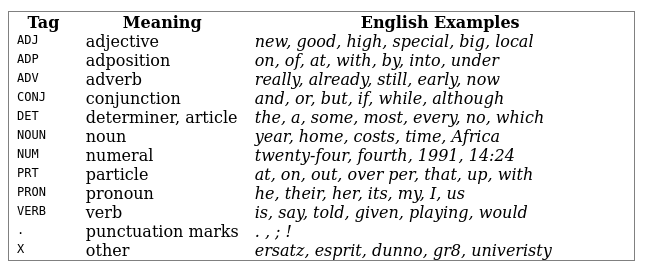

In [ ]:
nltk.download('averaged_perceptron_tagger')

tagged = nltk.pos_tag(tokens)
tagged

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('At', 'IN'),
 ('eight', 'CD'),
 ("o'clock", 'NN'),
 ('on', 'IN'),
 ('Thursday', 'NNP'),
 ('morning', 'NN'),
 ('Arthur', 'NNP'),
 ('did', 'VBD'),
 ("n't", 'RB'),
 ('feel', 'VB'),
 ('very', 'RB'),
 ('good', 'JJ'),
 ('.', '.')]

# [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

Го в ноутбук из [**туториала pytorch**](https://colab.research.google.com/drive/1ItNAiZtN8joPGP1nzHP0I0-8k2mp_cmS?usp=sharing)

Больше материалов про **RNN**

* классификация имен с помощью [character-level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* генерация паролей с помощью character-level RNN (ок, но зачем?)))


# Доп материалы

* [Voita word_embeddings](https://lena-voita.github.io/nlp_course/word_embeddings.html)
* [Habr W2V в картинках](https://habr.com/ru/post/446530/)
* [YDS RNN](https://github.com/yandexdataschool/Practical_DL/tree/fall21/week06_rnn)

# Блиц

## Какие проблемы могут быть, если использовать OHE эмбэддинги для слов?

<!-- * одинаковое расстояние между всеми словами, нелья как-то определить меру близости
* гигантские размерности -->

## Сколько матриц обучается в Word2Vec?

<!-- Две. Представление слова, если оно в центре. И представление, если оно контекст.

**Какие эмбэдинги используются после обучения?** -->


## Зачем нужен negative sampling во время обучения W2V?

<!-- Это оптимизация, которая позоляет обновлять фиксированное относительно небольшое количество контекстных векторов. 

[Voita w2v_negative_sampling](https://lena-voita.github.io/nlp_course/word_embeddings.html#w2v_negative_sampling) -->

## Какие приемущества у FastText по сравнению в W2V?

<!-- Позволяет получить эмбеддинги для слов, которых не было в обучающей выборке за счет использвоания n-грамм -->

## Мы получали эмбэддинги для слов, для триграмм. Для чего еще можно получать эмбэддинги? Можно из разных областей, например, в химии?

<!-- Вообще говоря, для чего угодно) В химии мможно сделать более умное разбиение химических формул на части (один токен = одно вещество). И обучить эмбэддинги для химических формул. И предсказывать какие-нибудь свойства соединений, например. Работать, скорее всего, будет не очень хорошо, в таком варианте, но идея прикольная). Так же можно получать эмбэддинги для зуков и т д. -->

## Какие проблемы есть у RNN?

<!--
* долго обучается и вычисляется (а почему?)
* затухающие градиенты
* плохо работают с долгосрочными зависимостями (помнят лишь небольшой контекст)
* контекст учитывается только слева направо
-->


## Что будет, если настекать 2 RNN'ки?

<!--
Получится более глубокая сеть :)

Еще можно проходиться не слева направо, а справа налево. И в результате получим 2 разных представления.
-->


## Как можно было бы использовать сверточные сети для работы с текстом? 

_Намекну, что кроме `nn.Conv2d` есть еще `nn.Conv1d`_

